In [1]:
# Written in Julia 1.6.1
# Packages loading and physical variables
using PyCall, PyPlot, Peaks, Statistics
np=pyimport("numpy")
Hartree_to_eV = 27.2;

In [2]:
## This notebook loads and analyzes Density Functional Theory (DFT) Calculations (from JDFTx)
# - Cluster models 1 to 3 (in Supplementary Information)
# - Bulk model (in main text)

# Cluster models 1 to 3

In [3]:
# Plotting parameters
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["font.size"] = 15
rcParams["legend.fontsize"] = "small"
rcParams["axes.labelsize"] = "xx-large"
rcParams["axes.titlesize"] = "xx-large"
rcParams["xtick.labelsize"] = "xx-large"
rcParams["ytick.labelsize"] = "xx-large"
rcParams["font.sans-serif"] = "Arial"
rcParams["font.family"] = "sans-serif"
rcParams["figure.figsize"] = (6, 6);

In [4]:
dir_cluster1 = string(pwd(), "/STH Defects With Hybrid Functionals and DFT+U/clusterresults/cluster1/BB1K");
dir_cluster3 = string(pwd(), "/STH Defects With Hybrid Functionals and DFT+U/clusterresults/cluster3/BB1K");

In [5]:
#Cluster Models: Calculating Magnetic Moments
println("Cluster 1 Mag Moments: ", filter!(line -> contains(line, "magnetic-moments O"), readlines("$dir_cluster1/cluster152.out")))
println("Cluster 1 Shared Spin Density: ", +0.594 +0.185)
println("Cluster 2 Mag Moments: ", filter!(line -> contains(line, "magnetic-moments O"), readlines("$dir_cluster1/cluster142.out")))
println("Cluster 2 Shared Spin Density: ", -0.594 -0.202)
println("Cluster 3 Mag Moments: ", filter!(line -> contains(line, "magnetic-moments O"), readlines("$dir_cluster3/cluster31.out")))
println("Cluster 3 Shared Spin Density: ", -0.135 -0.223)

Cluster 1 Mag Moments: ["# magnetic-moments O +0.007 +0.594 +0.026 +0.185"]
Cluster 1 Shared Spin Density: 0.7789999999999999
Cluster 2 Mag Moments: ["# magnetic-moments O -0.010 -0.594 -0.020 -0.202"]
Cluster 2 Shared Spin Density: -0.796
Cluster 3 Mag Moments: ["# magnetic-moments O -0.135 -0.223"]
Cluster 3 Shared Spin Density: -0.358


In [6]:
# Reading functions
function return_rexcitations(Filename::AbstractString)
    return np.loadtxt(Filename, skiprows=6, usecols=[3, 6])
end
function returnp(Filename::AbstractString, nbands::Integer, k_idx::Integer)
    return np.reshape(np.fromfile(Filename, dtype=np.complex), (2, 3, nbands, nbands))[k_idx, :, :, :]
end
function returnpsquared(p::Array{<:ComplexF64, 3})
    pxsqrd = (abs.(p[1, :, :])).^2
    pysqrd = (abs.(p[2, :, :])).^2
    pzsqrd = (abs.(p[3, :, :])).^2
    return pxsqrd+pysqrd+pzsqrd
end
function returnpsquared(p::Array{<:ComplexF64, 3}, direction::Integer)
    return (abs.(p[direction, :, :])).^2
end
function returnmu(Filename::AbstractString)
    parse(Float64, split(readlines(Filename)[occursin.("mu", readlines(Filename))][1])[3])
end;

In [7]:
# Get excitations 
excitations_cluster1 = return_rexcitations("$dir_cluster1/cluster152.Excitations");
excitations_cluster2 = return_rexcitations("$dir_cluster1/cluster142.Excitations");
excitations_cluster3 = return_rexcitations("$dir_cluster3/cluster31.Excitations");

In [8]:
# Optional: displays output of DFT calculation
# run(`cat "$dir_cluster3/cluster31.Excitations"`);

In [9]:
# Calculates cluster 1 (energy levels)
energies_cluster1 = np.fromfile("$dir_cluster1/cluster152.eigenvals")
energiesup_cluster1 = energies_cluster1[1:48];
energiesdn_cluster1 = energies_cluster1[49:96];

μ1 = returnmu("$dir_cluster1/cluster152.eigStats")
momentaup_cluster1 = returnp("$dir_cluster1/cluster152.momenta", 48, 1);
momentaupsqrd_cluster1 = returnpsquared(momentaup_cluster1);

momentadn_cluster1 = returnp("$dir_cluster1/cluster152.momenta", 48, 2);
momentadnsqrd_cluster1 = returnpsquared(momentadn_cluster1);

In [10]:
# Calculates cluster 2 (energy levels)
energies_cluster2 = np.fromfile("$dir_cluster1/cluster142.eigenvals")
energiesup_cluster2 = energies_cluster2[1:48];
energiesdn_cluster2 = energies_cluster2[49:96];

μ2 = returnmu("$dir_cluster1/cluster142.eigStats")
momentaup_cluster2 = returnp("$dir_cluster1/cluster142.momenta", 48, 1);
momentaupsqrd_cluster2 = returnpsquared(momentaup_cluster2);

momentadn_cluster2 = returnp("$dir_cluster1/cluster142.momenta", 48, 2);
momentadnsqrd_cluster2 = returnpsquared(momentadn_cluster2);

In [11]:
# Calculates cluster 3 (energy levels)
energies_cluster3 = np.fromfile("$dir_cluster3/cluster31.eigenvals")
energiesup_cluster3 = energies_cluster3[1:28];
energiesdn_cluster3 = energies_cluster3[29:end];

μ3= returnmu("$dir_cluster3/cluster31.eigStats")
momentaup_cluster3 = returnp("$dir_cluster3/cluster31.momenta", 28, 1);
momentaupsqrd_cluster3 = returnpsquared(momentaup_cluster3);
momentaupsqrd_cluster3_x = returnpsquared(momentaup_cluster3, 1);
momentaupsqrd_cluster3_y = returnpsquared(momentaup_cluster3, 2);
momentaupsqrd_cluster3_z = returnpsquared(momentaup_cluster3, 3);

momentadn_cluster3 = returnp("$dir_cluster3/cluster31.momenta", 28, 2);
momentadnsqrd_cluster3 = returnpsquared(momentadn_cluster3);
momentadnsqrd_cluster3_x = returnpsquared(momentadn_cluster3, 1);

In [12]:
# Calculates cluster 1 (spectrum momentum matrix)
pexcitations_cluster1 = zeros(500)
broadening = .1
for idx in 1:27
    e1 = energiesdn_cluster1[idx]*Hartree_to_eV
    e2 = energiesdn_cluster1[28]*Hartree_to_eV
    diffe = e2-e1
    strength = 2/3*Hartree_to_eV*momentadnsqrd_cluster1[idx, 28]/diffe
    pexcitations_cluster1 += strength*exp.(-(diffe .- range(1, 3, length=500) ).^2 ./broadening^2 )
end

In [13]:
# Calculates cluster 2 (spectrum momentum matrix)
pexcitations_cluster2 = zeros(500)
broadening = .13
for idx in 1:27
    e1 = energiesup_cluster2[idx]*Hartree_to_eV
    e2 = energiesup_cluster2[28]*Hartree_to_eV

    diffe = e2-e1
    strength = 2/3*Hartree_to_eV*momentaupsqrd_cluster2[idx, 28]/diffe
    pexcitations_cluster2 += strength*exp.(-(diffe .- range(1, 3, length=500) ).^2 ./broadening^2 )
end

In [14]:
# Calculates cluster 3 (spectrum momentum matrix)
pexcitations_cluster3 = zeros(500)
pexcitations_cluster3_x = zeros(500)
pexcitations_cluster3_y = zeros(500)
pexcitations_cluster3_z = zeros(500)

broadening = .1
for idx in 1:15
    e1 = energiesup_cluster3[idx]*Hartree_to_eV
    e2 = energiesup_cluster3[16]*Hartree_to_eV
    diffe = e2-e1
    strength = 2/3*Hartree_to_eV*momentaupsqrd_cluster3[idx, 16]/diffe
    strength_x = 2/3*Hartree_to_eV*momentaupsqrd_cluster3_x[idx, 16]/diffe
    strength_y = 2/3*Hartree_to_eV*momentaupsqrd_cluster3_y[idx, 16]/diffe
    strength_z = 2/3*Hartree_to_eV*momentaupsqrd_cluster3_z[idx, 16]/diffe

    pexcitations_cluster3 += strength*exp.(-(diffe .- range(1, 3, length=500) ).^2 ./broadening^2 )
    pexcitations_cluster3_x += strength_x*exp.(-(diffe .- range(1, 3, length=500) ).^2 ./broadening^2 )
    pexcitations_cluster3_y += strength_y*exp.(-(diffe .- range(1, 3, length=500) ).^2 ./broadening^2 )
    pexcitations_cluster3_z += strength_z*exp.(-(diffe .- range(1, 3, length=500) ).^2 ./broadening^2 )

end

In [15]:
# Calculates cluster 1 (spectrum dipole matrix)
rexcitations_cluster1 = zeros(500)
broadening = .1
for trans in eachrow(excitations_cluster1)
    diffe, strength = trans
    rexcitations_cluster1 += diffe*strength*exp.(-(diffe*Hartree_to_eV .- range(1, 3, length=500) ).^2 ./broadening^2 )
end

In [16]:
# Calculates cluster 2 (spectrum dipole matrix)
rexcitations_cluster2 = zeros(500)
broadening = .15
for trans in eachrow(excitations_cluster2)
    diffe, strength = trans
    rexcitations_cluster2 += diffe*strength*exp.(-(diffe*Hartree_to_eV .- range(1, 3, length=500) ).^2 ./broadening^2 )
end

In [17]:
# Calculates cluster 3 (spectrum dipole matrix)
rexcitations_cluster3 = zeros(500)
broadening = .1
for trans in eachrow(excitations_cluster3)
    diffe, strength = trans
    rexcitations_cluster3 += diffe*strength*exp.(-(diffe*Hartree_to_eV .- range(1, 3, length=500) ).^2 ./broadening^2 )
end

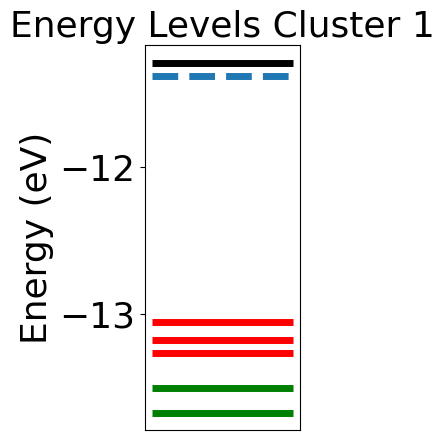

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


In [18]:
# Plots cluster 1 (Energy levels)
figure(figsize = (2, 5))
hlines([energiesdn_cluster1[23]*Hartree_to_eV], 0, 1, linewidth=5, color = :green)
hlines([energiesdn_cluster1[24]*Hartree_to_eV], 0, 1, linewidth=5, color = :green)
hlines([energiesdn_cluster1[25]*Hartree_to_eV], 0, 1, linewidth=5, color = :red)
hlines([energiesdn_cluster1[26]*Hartree_to_eV], 0, 1, linewidth=5, color = :red)
hlines([energiesdn_cluster1[27]*Hartree_to_eV], 0, 1, linewidth=5, color = :red)
hlines([energiesdn_cluster1[28]*Hartree_to_eV], 0, 1, linewidth=5, color = :black)
hlines(μ1*Hartree_to_eV, 0, 1, linewidth=5, linestyle="--", label="Chemical Potential")
ylabel("Energy (eV)")
#legend()
xticks(Float64[])
title("Energy Levels Cluster 1");

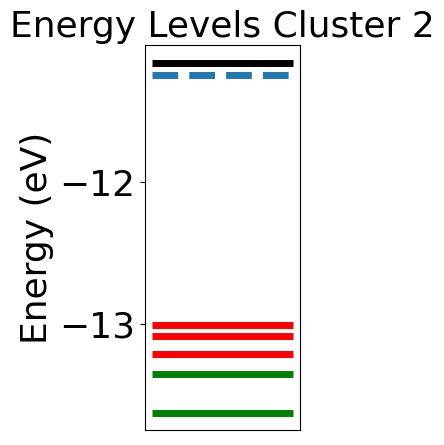

In [19]:
# Plots cluster 2 (Energy levels)
figure(figsize = (2, 5))
hlines([energiesup_cluster2[23]*Hartree_to_eV], 0, 1, linewidth=5, color = :green)
hlines([energiesup_cluster2[24]*Hartree_to_eV], 0, 1, linewidth=5, color = :green)
hlines([energiesup_cluster2[25]*Hartree_to_eV], 0, 1, linewidth=5, color = :red)
hlines([energiesup_cluster2[26]*Hartree_to_eV], 0, 1, linewidth=5, color = :red)
hlines([energiesup_cluster2[27]*Hartree_to_eV], 0, 1, linewidth=5, color = :red)
hlines([energiesup_cluster2[28]*Hartree_to_eV], 0, 1, linewidth=5, color = :black)
ylabel("Energy (eV)")
hlines(μ2*Hartree_to_eV, 0, 1, linestyle="--", linewidth=5)
xticks(Float64[])
title("Energy Levels Cluster 2");

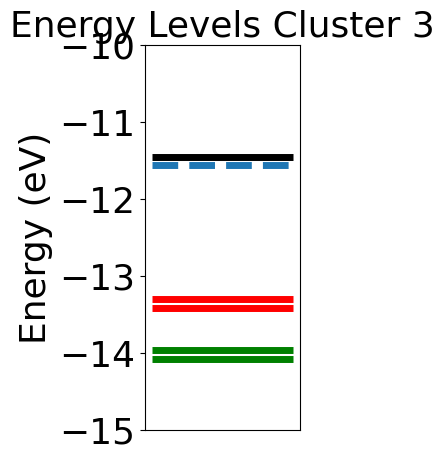

In [20]:
# Plots cluster 3 (Energy levels)
figure(figsize = (2, 5))
hlines([energiesup_cluster3[12]*Hartree_to_eV], 0, 1, linewidth=5, color = :green)
hlines([energiesup_cluster3[13]*Hartree_to_eV], 0, 1, linewidth=5, color = :green)
hlines([energiesup_cluster3[14]*Hartree_to_eV], 0, 1, linewidth=5, color = :red)
hlines([energiesup_cluster3[15]*Hartree_to_eV], 0, 1, linewidth=5, color = :red)
hlines([energiesup_cluster3[16]*Hartree_to_eV], 0, 1, linewidth=5, color = :black)
ylabel("Energy (eV)")
hlines(μ3*Hartree_to_eV, 0, 1, linewidth=5, linestyle="--")
title("Energy Levels Cluster 3")
ylim(-15, -10)
xticks(Float64[]);

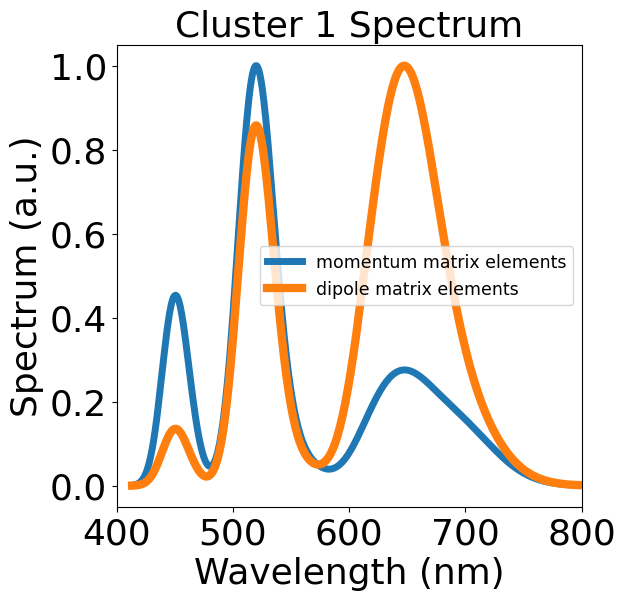

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


In [21]:
# Plots cluster 1 (spectrum)
plot(1240 ./ range(1, 3, length=500), pexcitations_cluster1/maximum(pexcitations_cluster1), linewidth=5, label = "momentum matrix elements")
plot(1240 ./ range(1, 3, length=500), rexcitations_cluster1./(maximum(rexcitations_cluster1)), linewidth=6, label="dipole matrix elements")
xlim([400, 800])
legend()
ylabel("Spectrum (a.u.)")
title("Cluster 1 Spectrum")
xlabel("Wavelength (nm)");

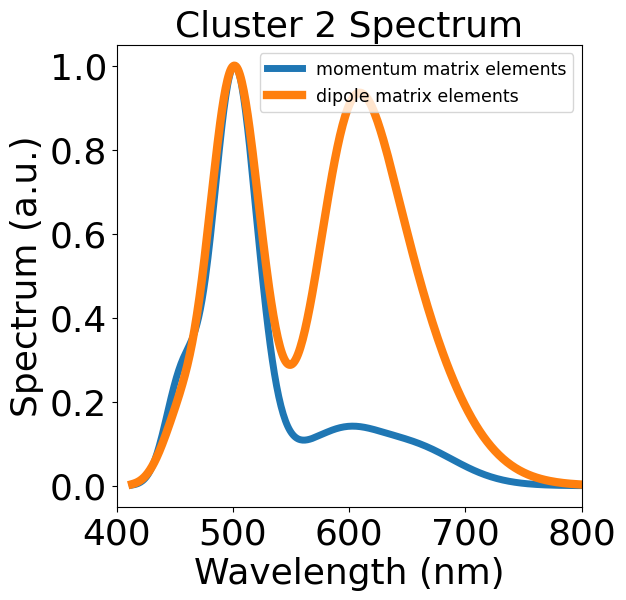

In [22]:
# Plots cluster 2 (spectrum)
plot(1240 ./ range(1, 3, length=500), pexcitations_cluster2/maximum(pexcitations_cluster2), linewidth=5, label = "momentum matrix elements")
plot(1240 ./ range(1, 3, length=500), rexcitations_cluster2./(maximum(rexcitations_cluster2)), linewidth=6, label="dipole matrix elements")
xlim([400, 800])
legend()
ylabel("Spectrum (a.u.)")
title("Cluster 2 Spectrum")
xlabel("Wavelength (nm)");

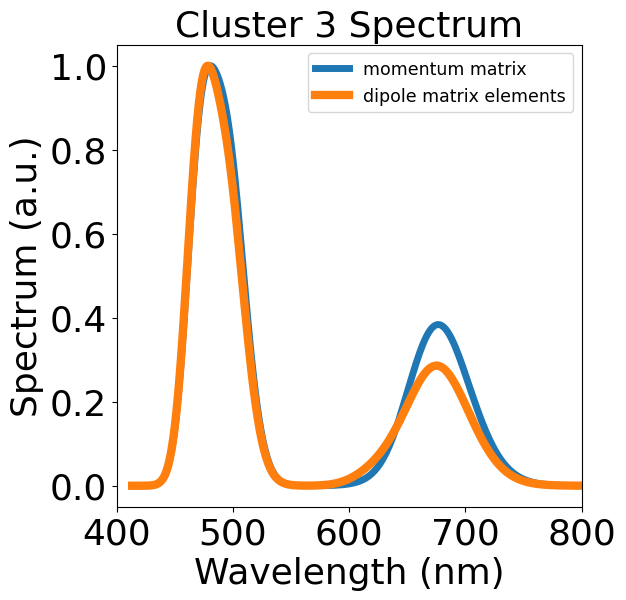

In [23]:
# Plots cluster 3 (spectrum)
plot(1240 ./ range(1, 3, length=500), pexcitations_cluster3./maximum(pexcitations_cluster3), linewidth=5, label = "momentum matrix")
plot(1240 ./ range(1, 3, length=500), rexcitations_cluster3./(maximum(rexcitations_cluster3)), linewidth=6, label="dipole matrix elements")
xlim([400, 800])
ylabel("Spectrum (a.u.)")
xlabel("Wavelength (nm)")
title("Cluster 3 Spectrum")
legend();

## Bulk Model

In [24]:
# Reads data from bulk model
bulk_dir = string(pwd(), "/STH Defects With Hybrid Functionals and DFT+U/clusterresults/Bulk/BB1K/alteredlattice");

In [25]:
# We do things differently here, because there are many states:
momenta = np.reshape(np.fromfile("$bulk_dir/alpha.momenta", np.complex), (224, 3, 36, 36))
momenta_sqrd = (abs.(momenta)).^2
bulk_excitations = np.loadtxt("$bulk_dir/alpha.Excitations", skiprows=6, usecols=[3, 6]);
## Sanity Check 
@assert isapprox(0, abs(momenta[1, 1, 10, 11]-np.conj(momenta[1, 1, 11, 10])), atol=1e-10)

In [26]:
# Calculates bulk spectrum (dipole matrix elements)
bulk_rspectrum = zeros(500)
broadening=0.1
energy_range = range(1.3, 5, length=500)
for (e, rsq) in zip(bulk_excitations[:, 1], bulk_excitations[:, 2])
    bulk_rspectrum += rsq*e*exp.(-((energy_range .- Hartree_to_eV*e).^2)/broadening^2)
end

In [27]:
# Calculates bulk spectrum (energy levels)
energies=np.reshape(np.fromfile("$bulk_dir/alpha.eigenvals"), (224, 36))
energies_up=energies[1:112, :]
energies_dn=energies[113:end, :]
mean_dns = [mean(es) for es in eachcol(energies_dn)]
mean_dns = mean_dns[20:30]
mean_ups = [mean(es) for es in eachcol(energies_up)]
mean_ups = mean_ups[20:30];

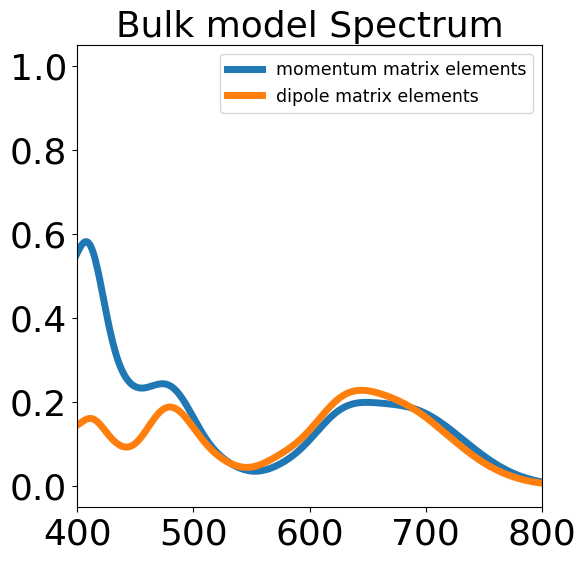

In [28]:
# Calculates bulk spectrum (momentum matrix elements)
bulk_pspectrum = zeros(500)
broadening=0.1
μ = 0.111873*Hartree_to_eV
energy_range = range(1.3, 5, length=500)
for (kpoint, band1, band2) in Tuple.(CartesianIndices(rand(112, 36, 36)))
    e1 = energies_dn[kpoint, band1]; e2 = energies_dn[kpoint, band2]
    e1*Hartree_to_eV < μ || continue
    e2*Hartree_to_eV > μ || continue
    e = e2-e1
    psquared = momenta_sqrd[kpoint+112, 1, band1, band2]+momenta_sqrd[kpoint+112, 2, band1, band2]+momenta_sqrd[kpoint+112, 3, band1, band2]
    bulk_pspectrum += (psquared/e)*exp.(-((energy_range .- e*Hartree_to_eV).^2)/broadening^2)
end
plot(1240 ./ energy_range, bulk_pspectrum./maximum(bulk_pspectrum), linewidth=5, label="momentum matrix elements")
plot(1240 ./ energy_range, bulk_rspectrum./maximum(bulk_rspectrum), linewidth=5, label="dipole matrix elements")
title("Bulk model Spectrum")
legend()
xlim(400, 800);

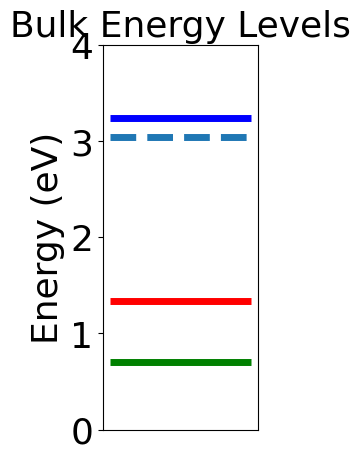

In [29]:
# Plot energy level structure (bulk model)
figure(figsize = (2, 5))
for dn_e in mean_dns[3:5]
    dn_e*Hartree_to_eV > μ && hlines(dn_e*Hartree_to_eV, 0, 10, color="blue", linewidth=5);
    dn_e*Hartree_to_eV < μ && dn_e*Hartree_to_eV < 1.0 && hlines(dn_e*Hartree_to_eV, 0, 10, color="green", linewidth=5);
    dn_e*Hartree_to_eV < μ && dn_e*Hartree_to_eV > 1.0 && hlines(dn_e*Hartree_to_eV, 0, 10, color="red", linewidth=5);
end
hlines(0.111873*Hartree_to_eV, 0, 10, linewidth=5, linestyle="--");
title("Bulk Energy Levels");
ylabel("Energy (eV)")
ylim([0,4])
xticks(Float64[]);

# Obtaining Hyperfine Parameters

In [77]:
Fermi_Contact = Dict{Tuple{AbstractString, Integer}, Float64}()
for line in readlines("$bulk_dir/alpha.hyperfine.out")[483:491]
    all_data = split(line)
    atom_type = all_data[1]
    atom_id = parse(Int, all_data[2])
    contact = parse(Float64, all_data[end])
    Fermi_Contact[(atom_type, atom_id)] = contact
end;

In [75]:
for ((atom, _), contact) in Fermi_Contact
    println("Atom ", atom, " with Fermi Contact term ", contact, " mT")
end

Atom O with Fermi Contact term -2.718438 mT
Atom O with Fermi Contact term -1.999695 mT
Atom Si with Fermi Contact term -0.871278 mT
Atom Si with Fermi Contact term 0.201306 mT
Atom Si with Fermi Contact term 0.880785 mT
Atom O with Fermi Contact term -0.01696 mT
Atom O with Fermi Contact term -0.21555 mT
Atom O with Fermi Contact term -0.149679 mT
Atom O with Fermi Contact term -0.517427 mT


In [92]:
Dipole_Interaction = Dict{Tuple{AbstractString, Integer, AbstractString}, Float64}()
for line in readlines("$bulk_dir/alpha.hyperfine.out")[430:464]
    all_data = split(line)
    try
    atom_type = all_data[1]
    atom_id = parse(Int, all_data[2])
    direction =  all_data[3][1:3]
    dipole = parse(Float64, all_data[4])
    Dipole_Interaction[(atom_type, atom_id, direction)] = dipole
    catch
    end
end;

In [100]:
for ((Atom, ID, Direction), Dipole) in Dipole_Interaction
    ID > 2 && continue
    println(Atom, ID, " has dipole interaction ", Dipole, " in direction ", Direction , "\n")
end

O2 has dipole interaction 1.428 in direction Axx

O2 has dipole interaction -2.9258 in direction Azz

O2 has dipole interaction 1.4978 in direction Ayy

O1 has dipole interaction 1.6396 in direction Axx

O1 has dipole interaction -3.3361 in direction Azz

O1 has dipole interaction 1.6965 in direction Ayy



In [103]:
for ((Atom, ID, Direction), Dipole) in Dipole_Interaction
    ID > 2 && continue
    Fermi = Fermi_Contact[Atom, ID]
    println(Atom, ID, " has total hyperfine parameter ", round(Dipole + Fermi, digits=3), " in direction ", Direction , "\n")
end

O2 has total hyperfine parameter -0.572 in direction Axx

O2 has total hyperfine parameter -4.925 in direction Azz

O2 has total hyperfine parameter -0.502 in direction Ayy

O1 has total hyperfine parameter -1.079 in direction Axx

O1 has total hyperfine parameter -6.055 in direction Azz

O1 has total hyperfine parameter -1.022 in direction Ayy



In [147]:
## Confirm that Dipole Terms sum to ze
flipped_Dipole = Dict(value => key for (key, value) in Dipole_Interaction)
for i in 1:9
    println("Sum of dipole terms for atom $i is ", round(sum(findall(x -> x[2]== i, flipped_Dipole)), digits=3) )
end

Sum of dipole terms for atom 1 is -0.0
Sum of dipole terms for atom 2 is -0.0
Sum of dipole terms for atom 3 is 0.0
Sum of dipole terms for atom 4 is -0.0
Sum of dipole terms for atom 5 is -0.0
Sum of dipole terms for atom 6 is 0.0
Sum of dipole terms for atom 7 is 0.0
Sum of dipole terms for atom 8 is 0.0
Sum of dipole terms for atom 9 is 0.0
